In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from tqdm import tqdm

from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity

PROJECT_ROOT = Path.cwd().resolve().parent
SR_PATH = PROJECT_ROOT / "repos" / "sr_nl"
sys.path.append(str(SR_PATH))

import ChaosFEX.feature_extractor as CFX

print("ChaosFEX loaded from:", CFX.__file__)

DATA_DIR = PROJECT_ROOT / "data" / "raw" / "recordings"
FIGURES_DIR = PROJECT_ROOT / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("Number of wav files:", len(list(DATA_DIR.glob("*.wav"))))


/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


> Numba JIT warmup successful for chaotic_sampler ...
> Numba JIT warmup successful for transform ...
ChaosFEX loaded from: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/ChaosFEX/feature_extractor.py
DATA_DIR: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/data/raw/recordings
Number of wav files: 3000


In [2]:
def parse_filename(fname: str):
    """
    Parse FSDD filename: {digit}_{speaker}_{index}.wav
    """
    name = fname.replace(".wav", "")
    digit, speaker, index = name.split("_", 2)
    return int(digit), speaker, int(index)

In [3]:
records = []

for wav_path in tqdm(sorted(DATA_DIR.glob("*.wav"))):
    digit, speaker, index = parse_filename(wav_path.name)
    
    # librosa.load -> sr=None, чтобы не ресемплить
    signal, sr = librosa.load(wav_path, sr=None)
    
    records.append({
        "file": wav_path.name,
        "digit": digit,
        "speaker": speaker,
        "length": len(signal),
        "sr": sr
    })

df = pd.DataFrame(records)

100%|██████████| 3000/3000 [00:00<00:00, 7718.97it/s]


In [4]:
min_length = df["length"].min()
max_length = df["length"].max()
mean_length = df["length"].mean()

min_length, max_length, mean_length

(1148, 18262, np.float64(3499.4746666666665))

In [5]:
SPEAKERS = df["speaker"].unique().tolist()
print("Speakers:", SPEAKERS)

Speakers: ['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']


In [6]:
def load_and_trim(wav_path, target_length):
    signal, sr = librosa.load(wav_path, sr=None)
    if len(signal) < target_length:
        raise ValueError("Signal shorter than target length")
    return signal[:target_length]

In [7]:
records = []   # ← добавка

for sp in SPEAKERS:
    print(f"\nProcessing speaker: {sp}")
    df_sp = df[df["speaker"] == sp].copy()

    signals = []
    labels = []

    for _, row in tqdm(df_sp.iterrows(), total=len(df_sp)):
        wav_path = DATA_DIR / row["file"]
        sig = load_and_trim(wav_path, min_length)

        signals.append(sig)
        labels.append(row["digit"])

    signals = np.stack(signals)
    labels = np.array(labels)

    records.append({
        "speaker": sp,
        "signals": signals,
        "labels": labels
    })



Processing speaker: george


100%|██████████| 500/500 [00:00<00:00, 11443.78it/s]



Processing speaker: jackson


100%|██████████| 500/500 [00:00<00:00, 6901.95it/s]



Processing speaker: lucas


100%|██████████| 500/500 [00:00<00:00, 13833.55it/s]



Processing speaker: nicolas


100%|██████████| 500/500 [00:00<00:00, 13948.10it/s]


Processing speaker: theo



100%|██████████| 500/500 [00:00<00:00, 13815.23it/s]



Processing speaker: yweweler


100%|██████████| 500/500 [00:00<00:00, 12434.35it/s]


In [8]:
def fft_features(signal):
    """
    Compute normalized Fourier magnitude coefficients.
    """
    spectrum = np.fft.rfft(signal)
    magnitude = np.abs(spectrum)
    
    # L2 normalization
    norm = np.linalg.norm(magnitude)
    if norm > 0:
        magnitude = magnitude / norm
    
    return magnitude


In [9]:
# Проверка на одном сигнале
feat_example = fft_features(signals[0])
feat_example.shape


(575,)

In [10]:
X = np.stack([fft_features(sig) for sig in tqdm(signals)])
y = labels.copy()


100%|██████████| 500/500 [00:00<00:00, 54674.56it/s]


In [11]:
def prepare_for_chaosfex(X):
    """
    EXACTLY as expected by ChaosFEX:
    - 2D array
    - float64
    - values in [0, 1]
    """
    X = np.asarray(X, dtype=np.float64)

    X_min = X.min(axis=1, keepdims=True)
    X_max = X.max(axis=1, keepdims=True)

    X_norm = (X - X_min) / (X_max - X_min + 1e-12)

    return X_norm


In [12]:
results = []

for sp in SPEAKERS:
    df_sp = df[df["speaker"] == sp].copy()

    print(f"\n=== Speaker {sp} ===")
    print("Total samples:", len(df_sp))
    print("\nSamples per digit:")
    display(df_sp["digit"].value_counts().sort_index())

    # --- baseline загрузка сигналов (без изменений по логике) ---
    signals = []
    labels = []

    for _, row in tqdm(df_sp.iterrows(), total=len(df_sp)):
        wav_path = DATA_DIR / row["file"]
        sig = load_and_trim(wav_path, min_length)
        signals.append(sig)
        labels.append(row["digit"])

    signals = np.stack(signals)
    labels = np.array(labels)

    # --- baseline FFT features (без изменений) ---
    X = np.stack([fft_features(sig) for sig in tqdm(signals)])
    y = labels.copy()

    # --- baseline prepare_for_chaosfex (без изменений) ---
    X = prepare_for_chaosfex(X)

    results.append({"speaker": sp, "X": X, "y": y})


=== Speaker george ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 47443.66it/s]


=== Speaker jackson ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 47883.46it/s]


=== Speaker lucas ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 54968.34it/s]


=== Speaker nicolas ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 55036.14it/s]



=== Speaker theo ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 59094.68it/s]



=== Speaker yweweler ===
Total samples: 500

Samples per digit:


digit
0    50
1    50
2    50
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: count, dtype: int64

100%|██████████| 500/500 [00:00<00:00, 49975.03it/s]


In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def chaosnet_decision(traindata, trainlabel, testdata):
    """
    1:1 copy of chaosnet() from Codes.py
    """
    NUM_FEATURES = traindata.shape[1]
    NUM_CLASSES = len(np.unique(trainlabel))

    mean_each_class = np.zeros((NUM_CLASSES, NUM_FEATURES))

    for label in range(NUM_CLASSES):
        mean_each_class[label, :] = np.mean(
            traindata[(trainlabel == label), :],
            axis=0
        )

    predicted_label = np.argmax(
        cosine_similarity(testdata, mean_each_class),
        axis=1
    )

    return predicted_label


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def run_sr_experiment(X, y, epsilon, q, chaos_length, b, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # === BASELINE SR CODE (БЕЗ ИЗМЕНЕНИЙ) ===
    F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
    F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

    y_pred = chaosnet_decision(F_train, y_train, F_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    return acc, f1


In [15]:
import numpy as np

speaker_scores = {}
speaker_best_eps = {}

eps_grid = np.arange(0.001, 1.001, 0.001)

for res in results:
    sp = res["speaker"]
    X = res["X"]
    y = res["y"]

    print(f"\n=== Speaker {sp} ===")

    f1_vals = []
    acc_vals = []

    for eps in eps_grid:
        acc, f1 = run_sr_experiment(
            X, y,
            epsilon=eps,
            q=0.34,
            chaos_length=10000,
            b=0.499,
            test_size=0.3,
            random_state=42
        )
        acc_vals.append(acc)
        f1_vals.append(f1)

    f1_vals = np.array(f1_vals)
    acc_vals = np.array(acc_vals)

    best_idx = int(np.argmax(f1_vals))
    best_eps = float(eps_grid[best_idx])
    best_f1  = float(f1_vals[best_idx])

    speaker_scores[sp] = f1_vals
    speaker_best_eps[sp] = (best_eps, best_f1)

    print(f"Best epsilon: {best_eps:.3f}")
    print(f"Best F1: {best_f1:.4f}")



=== Speaker george ===


KeyboardInterrupt: 

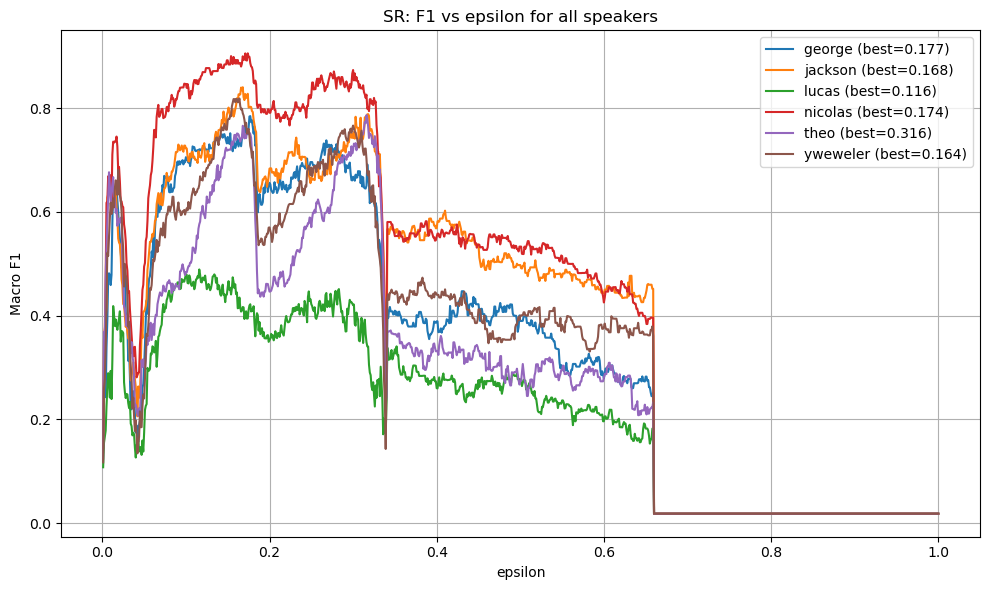

Saved to ../figures/SR_single_split_all_speakers.png


In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for sp in SPEAKERS:
    plt.plot(eps_grid, speaker_scores[sp], label=f"{sp} (best={speaker_best_eps[sp][0]:.3f})")

plt.xlabel("epsilon")
plt.ylabel("Macro F1")
plt.title("SR: F1 vs epsilon for all speakers")
plt.grid(True)
plt.legend()

save_path = "../figures/SR_single_split_all_speakers.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)

plt.show()
print(f"Saved to {save_path}")


In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def run_sr_kfold(X, y, epsilon, q, chaos_length, b, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    acc_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # === BASELINE SR CODE (БЕЗ ИЗМЕНЕНИЙ) ===
        F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
        F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

        y_pred = chaosnet_decision(F_train, y_train, F_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    return np.mean(acc_scores), np.mean(f1_scores)


In [42]:
import numpy as np

speaker_scores = {}
speaker_best_eps = {}

eps_grid = np.arange(0.001, 1.001, 0.001)

for res in results:
    sp = res["speaker"]
    X = res["X"]
    y = res["y"]

    print(f"\n=== Speaker {sp} ===")

    f1_vals = []
    acc_vals = []

    for eps in eps_grid:
        # ⬇⬇⬇ ВОТ ЭТА СТРОКА МЕНЯЕТСЯ ⬇⬇⬇
        acc, f1 = run_sr_kfold(
            X, y,
            epsilon=eps,
            q=0.34,
            chaos_length=10000,
            b=0.499,
            n_splits=5,          # ← 5-fold
            random_state=42
        )
        acc_vals.append(acc)
        f1_vals.append(f1)

    f1_vals = np.array(f1_vals)
    acc_vals = np.array(acc_vals)

    best_idx = int(np.argmax(f1_vals))
    best_eps = float(eps_grid[best_idx])
    best_f1  = float(f1_vals[best_idx])

    speaker_scores[sp] = f1_vals
    speaker_best_eps[sp] = (best_eps, best_f1)

    print(f"Best epsilon: {best_eps:.3f}")
    print(f"Best F1: {best_f1:.4f}")



=== Speaker george ===
Best epsilon: 0.175
Best F1: 0.8015

=== Speaker jackson ===
Best epsilon: 0.177
Best F1: 0.8381

=== Speaker lucas ===
Best epsilon: 0.156
Best F1: 0.4520

=== Speaker nicolas ===
Best epsilon: 0.160
Best F1: 0.8735

=== Speaker theo ===
Best epsilon: 0.313
Best F1: 0.7737

=== Speaker yweweler ===
Best epsilon: 0.167
Best F1: 0.7865


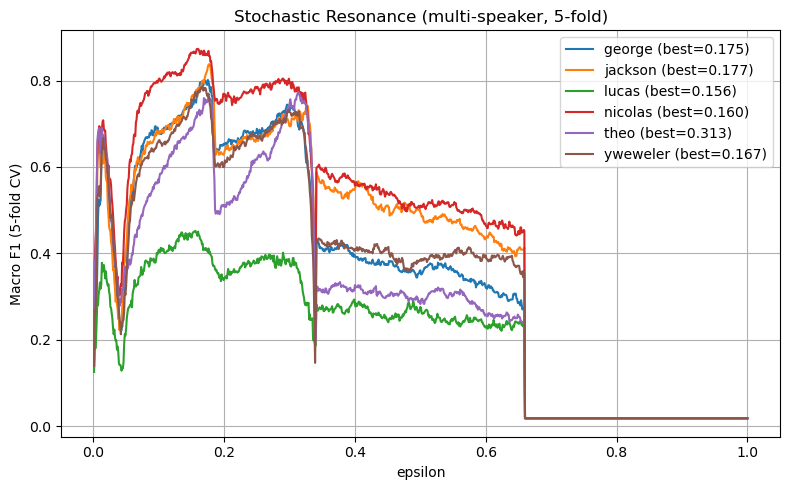

Saved to ../figures/SR_kfold_all_speakers.png


In [45]:
plt.figure(figsize=(8, 5))

for sp in SPEAKERS:
    plt.plot(eps_grid, speaker_scores[sp], label=f"{sp} (best={speaker_best_eps[sp][0]:.3f})")

plt.xlabel("epsilon")
plt.ylabel("Macro F1 (5-fold CV)")
plt.title("Stochastic Resonance (multi-speaker, 5-fold)")
plt.grid(True)
plt.legend()

save_path = "../figures/SR_kfold_all_speakers.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)

plt.show()
print(f"Saved to {save_path}")


# Эксперимент о влиянии длины сигнала

Гипотеза

Оптимальная длина сигнала может быть больше минимальной → больше спектральной информации → выше F1.

Мы хотим проверить:
как длина сигнала влияет на эффект stochastic resonance:

меняется ли форма SR-кривой

сдвигается ли оптимальный ε

растёт ли best F1 при большей длине сигнала

In [16]:
BASELINE_SPEAKER = "jackson"

df_baseline = df[df["speaker"] == BASELINE_SPEAKER].copy()

In [17]:
# ===============================
# Safe experiment: signal length
# ===============================

signal_lengths = [1000, 2000, 2753, 4000]
eps_grid = np.arange(0.001, 0.501, 0.005)

length_results = {}
length_stats = {}

for L in signal_lengths:
    print(f"\n=== Signal length: {L} ===")

    signals_L = []
    labels_L = []

    skipped = 0

    for _, row in df_baseline.iterrows():
        wav_path = DATA_DIR / row["file"]

        try:
            sig = load_and_trim(wav_path, L)
            signals_L.append(sig)
            labels_L.append(row["digit"])
        except ValueError:
            skipped += 1
            continue

    signals_L = np.array(signals_L)
    labels_L = np.array(labels_L)

    print(f"Loaded signals: {len(signals_L)} | Skipped: {skipped}")

    # --- FFT features (EXACTLY like baseline) ---
    X = np.stack([fft_features(sig) for sig in signals_L])
    y = labels_L.copy()

    # --- ChaosFEX preprocessing (EXACTLY like baseline) ---
    X = prepare_for_chaosfex(X)

    # --- SR experiment ---
    f1_vals = []

    for eps in eps_grid:
        _, f1 = run_sr_experiment(
            X, y,
            epsilon=eps,
            q=0.34,
            chaos_length=10000,
            b=0.499,
            test_size=0.3,
            random_state=42
        )
        f1_vals.append(f1)

    f1_vals = np.array(f1_vals)

    best_idx = int(np.argmax(f1_vals))
    best_f1 = float(f1_vals[best_idx])
    best_eps = float(eps_grid[best_idx])

    print(f"Best F1 = {best_f1:.4f} at ε = {best_eps:.3f}")

    length_results[L] = f1_vals
    length_stats[L] = {
        "best_f1": best_f1,
        "best_eps": best_eps,
        "num_samples": len(X),
        "skipped": skipped
    }



=== Signal length: 1000 ===
Loaded signals: 500 | Skipped: 0
Best F1 = 0.8275 at ε = 0.176

=== Signal length: 2000 ===
Loaded signals: 500 | Skipped: 0


SystemError: CPUDispatcher(<function _compute_measures at 0x309dc74c0>) returned a result with an exception set

# Truncation and zero-padding

Truncation: используем только сигналы длиной ≥ 4000, остальные отбрасываем

Zero-padding: все сигналы короче 4000 дополняем нулями до 4000

Сравниваем:

F1 vs ε

Best F1

стабильность кривой

In [18]:
def load_and_truncate(wav_path, target_length):
    signal, sr = librosa.load(wav_path, sr=None)
    if len(signal) < target_length:
        raise ValueError("Signal shorter than target length")
    return signal[:target_length]


def load_and_zero_pad(wav_path, target_length):
    signal, sr = librosa.load(wav_path, sr=None)
    if len(signal) >= target_length:
        return signal[:target_length]
    padded = np.zeros(target_length, dtype=signal.dtype)
    padded[:len(signal)] = signal
    return padded


In [19]:
TARGET_LENGTH = 4000

def prepare_dataset(df, mode="truncate"):
    signals = []
    labels = []
    skipped = 0

    for _, row in df.iterrows():
        try:
            if mode == "truncate":
                sig = load_and_truncate(DATA_DIR / row["file"], TARGET_LENGTH)
            elif mode == "pad":
                sig = load_and_zero_pad(DATA_DIR / row["file"], TARGET_LENGTH)
            else:
                raise ValueError("Unknown mode")

            signals.append(sig)
            labels.append(row["digit"])

        except ValueError:
            skipped += 1

    X = np.stack(signals)
    y = np.array(labels)

    print(f"Mode: {mode}")
    print(f"Loaded signals: {len(X)} | Skipped: {skipped}")

    return X, y


In [20]:
def extract_features(signals):
    X_fft = np.stack([fft_features(sig) for sig in signals])
    X_norm = prepare_for_chaosfex(X_fft)
    return X_norm


In [21]:
def run_length_experiment(df, mode, eps_grid):
    X_raw, y = prepare_dataset(df, mode=mode)

    # 🔒 защита от некорректного stratify
    unique, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    print(f"Min samples per class: {min_count}")

    if min_count < 2:
        print("⚠️ Skipping experiment: not enough samples per class")
        return None

    X = extract_features(X_raw)

    f1_vals = []

    for eps in eps_grid:
        _, f1 = run_sr_experiment(
            X, y,
            epsilon=eps,
            q=0.34,
            chaos_length=10000,
            b=0.499,
            test_size=0.3,
            random_state=42
        )
        f1_vals.append(f1)

    f1_vals = np.array(f1_vals)

    best_idx = np.argmax(f1_vals)
    print(f"Best F1 = {f1_vals[best_idx]:.4f} at ε = {eps_grid[best_idx]:.3f}")

    return f1_vals


In [22]:
eps_grid = np.arange(0.001, 1.001, 0.001)

# один спикер, как в baseline (например jackson)
df_sp = df[df["speaker"] == "jackson"].copy()

f1_truncate = run_length_experiment(df_sp, mode="truncate", eps_grid=eps_grid)
f1_pad      = run_length_experiment(df_sp, mode="pad", eps_grid=eps_grid)



Mode: truncate
Loaded signals: 235 | Skipped: 265
Min samples per class: 1
⚠️ Skipping experiment: not enough samples per class
Mode: pad
Loaded signals: 500 | Skipped: 0
Min samples per class: 50


SystemError: CPUDispatcher(<function _compute_measures at 0x309dc74c0>) returned a result with an exception set

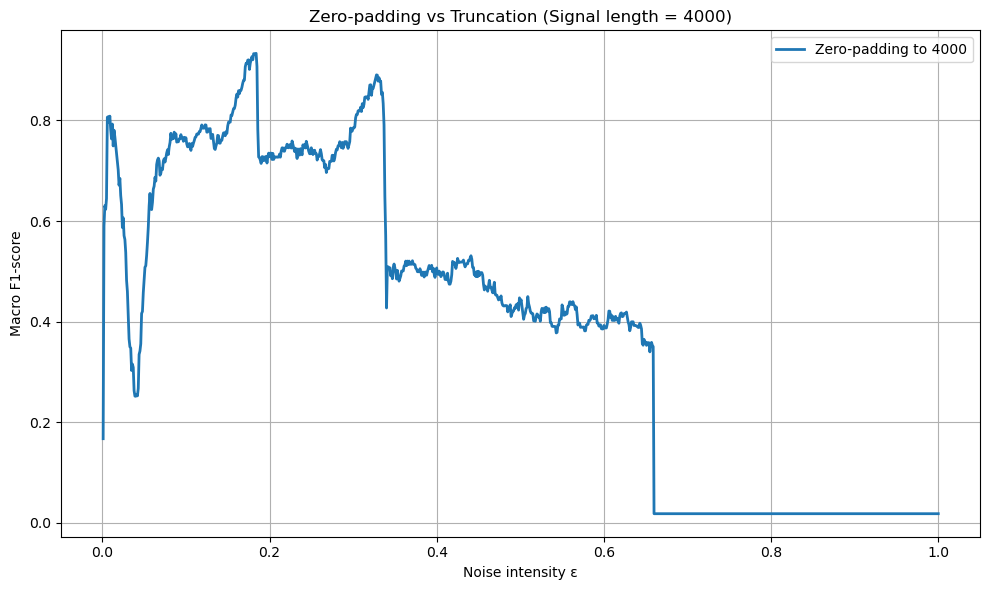

Saved to ../figures/zero_padding_jackson.png


In [59]:
plt.figure(figsize=(10, 6))

if f1_truncate is not None:
    plt.plot(eps_grid, f1_truncate, label="Truncation (≥4000)", linewidth=2)

if f1_pad is not None:
    plt.plot(eps_grid, f1_pad, label="Zero-padding to 4000", linewidth=2)

plt.xlabel("Noise intensity ε")
plt.ylabel("Macro F1-score")
plt.title("Zero-padding vs Truncation (Signal length = 4000)")
plt.legend()
plt.grid(True)

save_path = "../figures/zero_padding_jackson.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


# Эксперимент с random state

Мы хотим проверить:

Насколько стабилен результат ChaosFEX + SR при фиксированных гиперпараметрах, но разных случайных разбиениях данных?

Фиксируем:

длину сигнала (например, 2753, как в статье)

ε = лучшее (или разумное фиксированное)

q, b, chaos_length — как в baseline

Меняем:

random_state ∈ {0, 1, 2, ..., 49}

In [23]:
# === Stability analysis settings ===

EPSILON = 0.18        # возьми best ε с предыдущего эксперимента
SIGNAL_LENGTH = 2753
N_RUNS = 50           # количество random_state

random_states = list(range(N_RUNS))


In [24]:
# один спикер, как в baseline
df_sp = df[df["speaker"] == "jackson"].copy()

signals = []
labels = []

for _, row in df_sp.iterrows():
    try:
        sig = load_and_trim(DATA_DIR / row["file"], SIGNAL_LENGTH)
        signals.append(sig)
        labels.append(row["digit"])
    except ValueError:
        pass

signals = np.stack(signals)
labels = np.array(labels)

print("Signals shape:", signals.shape)
print("Labels shape:", labels.shape)


Signals shape: (500, 2753)
Labels shape: (500,)


In [25]:
X = np.stack([fft_features(sig) for sig in signals])
y = labels.copy()

X = prepare_for_chaosfex(X)

print("Feature matrix:", X.shape)


Feature matrix: (500, 1377)


In [26]:
from tqdm import tqdm

f1_scores = []
acc_scores = []

for rs in tqdm(random_states):
    acc, f1 = run_sr_experiment(
        X, y,
        epsilon=EPSILON,
        q=0.34,
        chaos_length=10000,
        b=0.499,
        test_size=0.3,
        random_state=rs
    )
    acc_scores.append(acc)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
acc_scores = np.array(acc_scores)


100%|██████████| 50/50 [00:03<00:00, 15.45it/s]


In [27]:
print("=== Stability results ===")
print(f"F1 mean : {f1_scores.mean():.4f}")
print(f"F1 std  : {f1_scores.std():.4f}")
print(f"F1 min  : {f1_scores.min():.4f}")
print(f"F1 max  : {f1_scores.max():.4f}")


=== Stability results ===
F1 mean : 0.9207
F1 std  : 0.0197
F1 min  : 0.8743
F1 max  : 0.9668


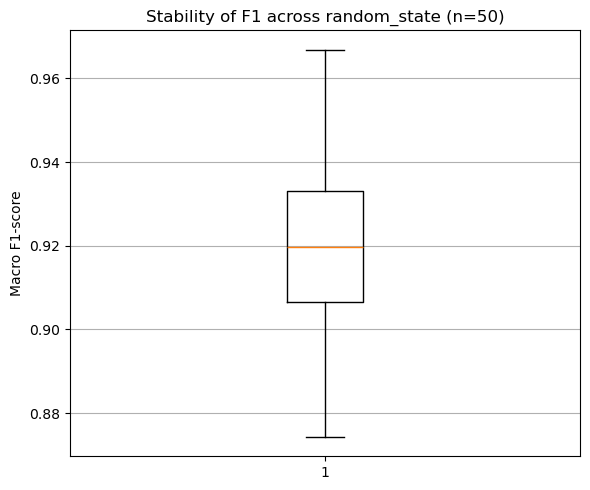

Saved to ../figures/SR_stability_analysis_box_plot.png


In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.boxplot(f1_scores, vert=True)
plt.ylabel("Macro F1-score")
plt.title("Stability of F1 across random_state (n=50)")
plt.grid(True, axis="y")

save_path = "../figures/SR_stability_analysis_box_plot.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


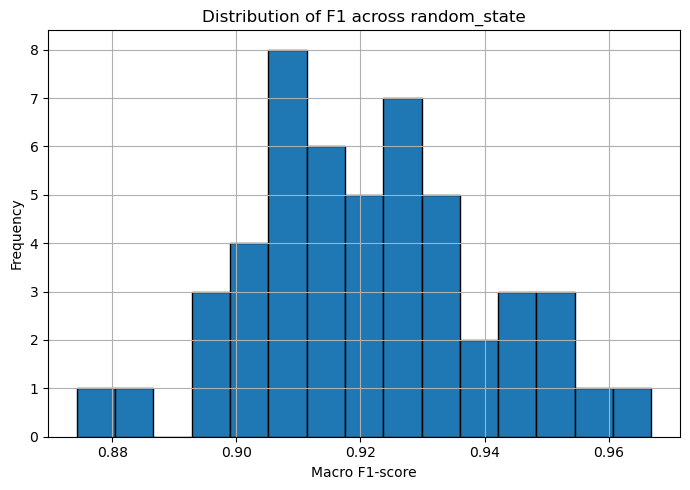

Saved to ../figures/SR_stability_analysis_hist.png


In [31]:
plt.figure(figsize=(7, 5))
plt.hist(f1_scores, bins=15, edgecolor="black")
plt.xlabel("Macro F1-score")
plt.ylabel("Frequency")
plt.title("Distribution of F1 across random_state")
plt.grid(True)

save_path = "../figures/SR_stability_analysis_hist.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


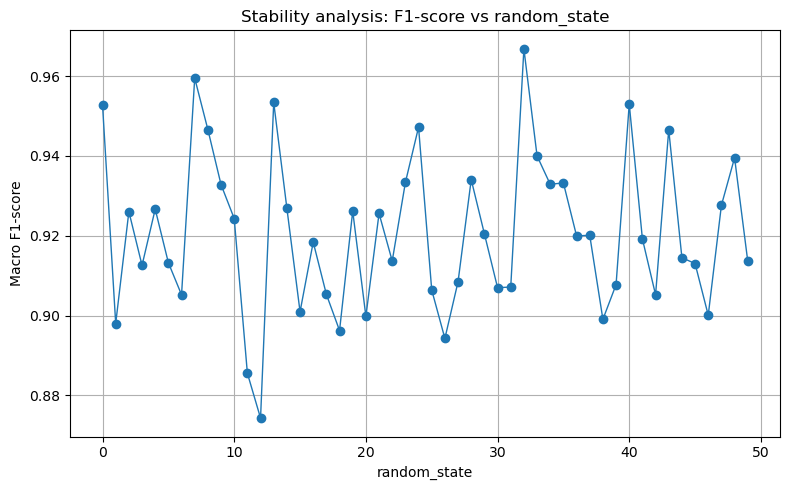

Saved to ../figures/SR_stability_analysis_f1_rs.png


In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(random_states, f1_scores, marker="o", linewidth=1)

plt.xlabel("random_state")
plt.ylabel("Macro F1-score")
plt.title("Stability analysis: F1-score vs random_state")

plt.grid(True)
save_path = "../figures/SR_stability_analysis_f1_rs.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


Напишем эксперимент для Jackson, только с random state 33

In [37]:
def prepare_for_chaosfex(X):
    """
    EXACTLY as expected by ChaosFEX:
    - 2D array
    - float64
    - values in [0, 1]
    """
    X = np.asarray(X, dtype=np.float64)

    X_min = X.min(axis=1, keepdims=True)
    X_max = X.max(axis=1, keepdims=True)

    X_norm = (X - X_min) / (X_max - X_min + 1e-12)

    return X_norm


In [38]:
X_norm = prepare_for_chaosfex(X)

print(X_norm.shape)
print(X_norm.dtype)
print("min/max:", X_norm.min(), X_norm.max())

(500, 1377)
float64
min/max: 0.0 0.999999999999


In [39]:
from sklearn.model_selection import KFold

def run_sr_experiment_kfold(X, y, q, b, epsilon, chaos_length=10000):
    kf = KFold(n_splits=5, shuffle=True, random_state=33)
    f1_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
        F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

        y_pred = chaosnet_decision(F_train, y_train, F_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [40]:
epsilon_grid = np.arange(0.001, 1.001, 0.001)
f1_kfold = []

for eps in epsilon_grid:
    f1 = run_sr_experiment_kfold(
        X_norm, y,
        q=0.34,
        b=0.499,
        epsilon=eps
    )
    f1_kfold.append(f1)

f1_kfold = np.array(f1_kfold)

print("Best k-fold F1:", f1_kfold.max())
print("Best epsilon:", epsilon_grid[np.argmax(f1_kfold)])


Best k-fold F1: 0.9168760201838813
Best epsilon: 0.181


In [43]:
np.savez(
    "../figures/SR_kfold_jackson_rs33.npz",
    epsilon=epsilon_grid,
    f1=f1_kfold
)
print("Saved results for random_state=33")


Saved results for random_state=33


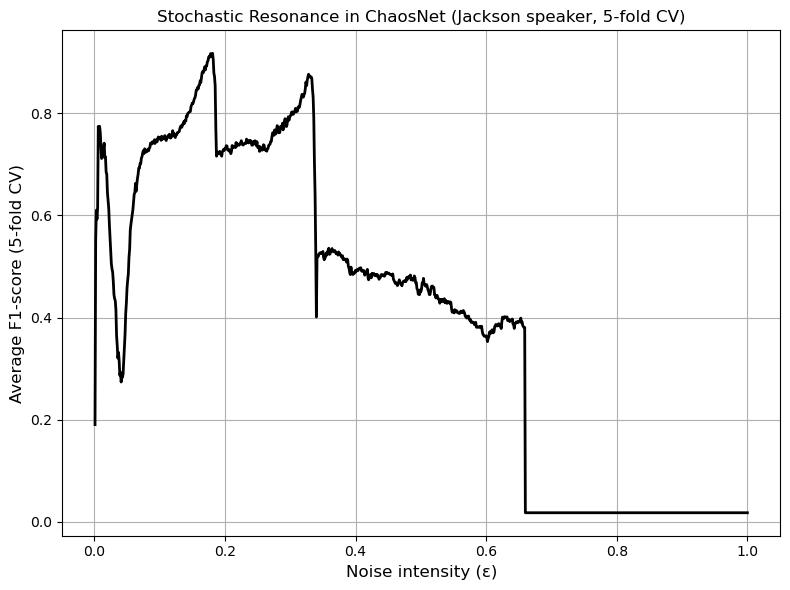

Saved to ../figures/SR_kfold_Jackson_33.png


In [42]:
plt.figure(figsize=(8, 6))
plt.plot(epsilon_grid, f1_kfold, color="black", linewidth=2)

plt.xlabel("Noise intensity (ε)", fontsize=12)
plt.ylabel("Average F1-score (5-fold CV)", fontsize=12)
plt.title("Stochastic Resonance in ChaosNet (Jackson speaker, 5-fold CV)")
plt.grid(True)

save_path = "../figures/SR_kfold_Jackson_33.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")

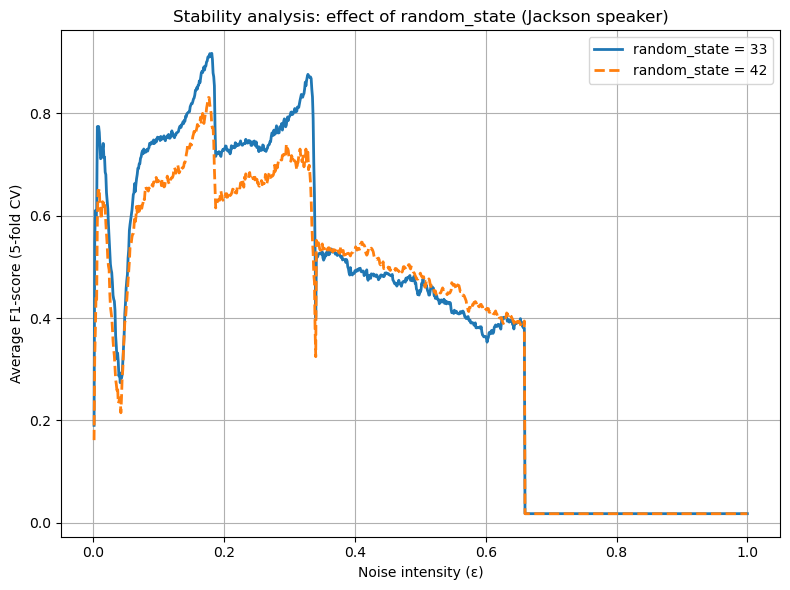

Saved to ../figures/SR_kfold_Jackson_33_VS_42.png


In [44]:
import numpy as np
import matplotlib.pyplot as plt

# загрузка
rs33 = np.load("../figures/SR_kfold_jackson_rs33.npz")
rs42 = np.load("../figures/SR_kfold_jackson_rs42.npz")

eps = rs33["epsilon"]
f1_33 = rs33["f1"]
f1_42 = rs42["f1"]

# график
plt.figure(figsize=(8, 6))

plt.plot(eps, f1_33, label="random_state = 33", linewidth=2)
plt.plot(eps, f1_42, label="random_state = 42", linewidth=2, linestyle="--")

plt.xlabel("Noise intensity (ε)")
plt.ylabel("Average F1-score (5-fold CV)")
plt.title("Stability analysis: effect of random_state (Jackson speaker)")
plt.legend()
plt.grid(True)

save_path = "../figures/SR_kfold_Jackson_33_VS_42.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


# Эксперимент с noise sensitivity

In [45]:
# === Grid step sensitivity experiment ===

speaker = "jackson"
random_state = 42

q = 0.34
b = 0.499
chaos_length = 10000
n_splits = 5


In [46]:
eps_grids = {
    "coarse (step=0.01)":  np.arange(0.01,  1.01, 0.01),
    "baseline (step=0.001)": np.arange(0.001, 1.001, 0.001),
    "fine (step=0.0005)": np.arange(0.0005, 1.0005, 0.0005),
}


In [47]:
res = next(r for r in results if r["speaker"] == speaker)
X = res["X"]
y = res["y"]

print("Data shape:", X.shape, y.shape)


Data shape: (500, 575) (500,)


In [48]:
from sklearn.model_selection import StratifiedKFold

def kfold_f1_for_eps(X, y, eps_grid):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mean_f1 = []

    for eps in eps_grid:
        f1_scores = []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            F_train = CFX.transform(X_train, q, chaos_length, eps, b)
            F_test  = CFX.transform(X_test,  q, chaos_length, eps, b)

            y_pred = chaosnet_decision(F_train, y_train, F_test)
            f1_scores.append(f1_score(y_test, y_pred, average="macro"))

        mean_f1.append(np.mean(f1_scores))

    return np.array(mean_f1)


In [49]:
grid_results = {}

for name, eps_grid in eps_grids.items():
    print(f"\nRunning grid: {name}")
    f1_vals = kfold_f1_for_eps(X, y, eps_grid)

    best_idx = np.argmax(f1_vals)
    print(f"Best ε = {eps_grid[best_idx]:.4f}, Best F1 = {f1_vals[best_idx]:.4f}")

    grid_results[name] = {
        "eps": eps_grid,
        "f1": f1_vals
    }



Running grid: coarse (step=0.01)
Best ε = 0.1800, Best F1 = 0.8171

Running grid: baseline (step=0.001)
Best ε = 0.1770, Best F1 = 0.8381

Running grid: fine (step=0.0005)
Best ε = 0.1785, Best F1 = 0.8438


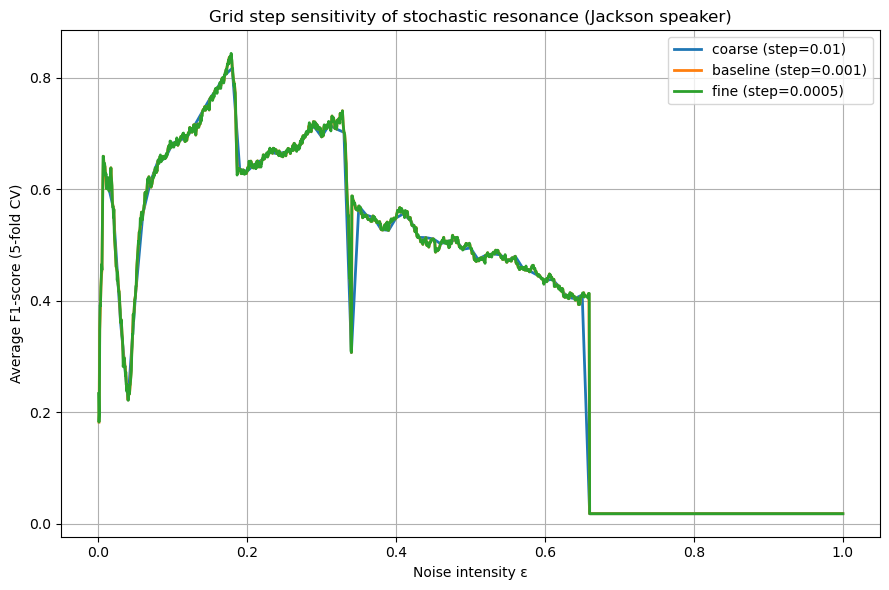

In [50]:
plt.figure(figsize=(9, 6))

for name, res in grid_results.items():
    plt.plot(res["eps"], res["f1"], label=name, linewidth=2)

plt.xlabel("Noise intensity ε")
plt.ylabel("Average F1-score (5-fold CV)")
plt.title("Grid step sensitivity of stochastic resonance (Jackson speaker)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("../figures/SR_grid_step_sensitivity.png", dpi=300)
plt.show()


# Эксперимент: Sensitivity analysis for q and b

In [51]:
speaker = "jackson"
signal_length = 2753
epsilon = best_eps  # из твоего SR-эксперимента
random_state = 42
n_splits = 5


In [52]:
q_grid = np.linspace(0.1, 0.6, 11)      # от слабой к сильной нелинейности
b_grid = np.linspace(0.45, 0.55, 11)    # около 0.5


In [53]:
results_qb = np.zeros((len(q_grid), len(b_grid)))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, q in enumerate(q_grid):
    for j, b in enumerate(b_grid):

        f1_scores = []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            F_train = CFX.transform(X_train, q, chaos_length, epsilon, b)
            F_test  = CFX.transform(X_test,  q, chaos_length, epsilon, b)

            y_pred = chaosnet_decision(F_train, y_train, F_test)
            f1_scores.append(f1_score(y_test, y_pred, average="macro"))

        results_qb[i, j] = np.mean(f1_scores)


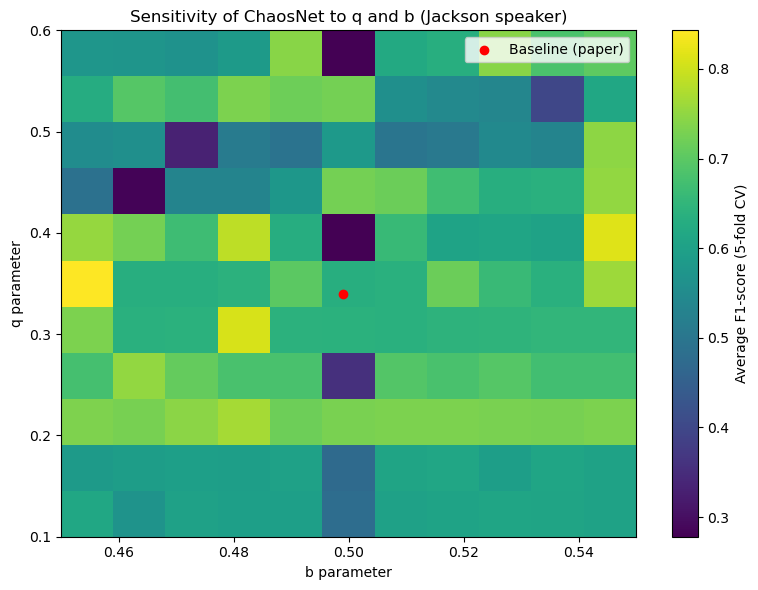

In [54]:
plt.figure(figsize=(8, 6))
plt.imshow(
    results_qb,
    origin="lower",
    aspect="auto",
    extent=[b_grid[0], b_grid[-1], q_grid[0], q_grid[-1]],
    cmap="viridis"
)

plt.colorbar(label="Average F1-score (5-fold CV)")
plt.xlabel("b parameter")
plt.ylabel("q parameter")
plt.title("Sensitivity of ChaosNet to q and b (Jackson speaker)")

plt.scatter([0.499], [0.34], color="red", label="Baseline (paper)")
plt.legend()

plt.tight_layout()
plt.savefig("../figures/SR_q_b_sensitivity.png", dpi=300)
plt.show()


In [55]:
speaker = "jackson"
signal_length = 2753
random_state = 42
chaos_length = 10000

eps_grid = np.arange(0.001, 1.001, 0.001)


In [56]:
params_baseline = {
    "q": 0.34,
    "b": 0.499,
    "label": "Baseline (paper)"
}

params_best = {
    "q": 0.327,
    "b": 0.45,
    "label": "Best (this work)"
}


In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def sr_curve(X, y, q, b):
    f1_vals = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    for eps in eps_grid:
        fold_scores = []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            F_train = CFX.transform(X_train, q, chaos_length, eps, b)
            F_test  = CFX.transform(X_test,  q, chaos_length, eps, b)

            y_pred = chaosnet_decision(F_train, y_train, F_test)
            fold_scores.append(f1_score(y_test, y_pred, average="macro"))

        f1_vals.append(np.mean(fold_scores))

    return np.array(f1_vals)


In [58]:
f1_baseline = sr_curve(X, y, q=0.34,  b=0.499)
f1_best     = sr_curve(X, y, q=0.327, b=0.45)


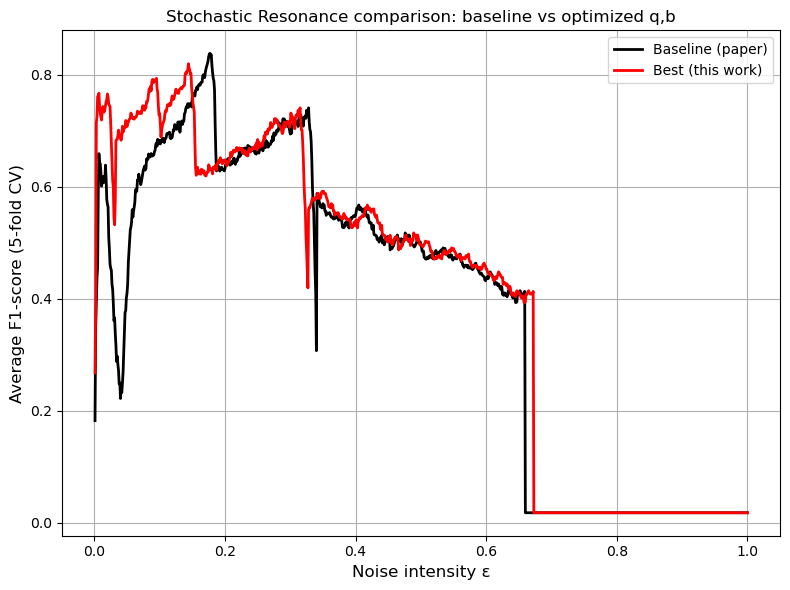

In [59]:
plt.figure(figsize=(8, 6))

plt.plot(eps_grid, f1_baseline, color="black", lw=2, label="Baseline (paper)")
plt.plot(eps_grid, f1_best, color="red", lw=2, label="Best (this work)")

plt.xlabel("Noise intensity ε", fontsize=12)
plt.ylabel("Average F1-score (5-fold CV)", fontsize=12)
plt.title("Stochastic Resonance comparison: baseline vs optimized q,b")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("../figures/SR_baseline_vs_best_qb.png", dpi=300)
plt.show()


In [60]:
q_grid = np.linspace(0.1, 0.6, 10)
b_grid = np.linspace(0.45, 0.55, 10)

max_f1_map = np.zeros((len(q_grid), len(b_grid)))
best_eps_map = np.zeros_like(max_f1_map)

for i, q in enumerate(q_grid):
    for j, b in enumerate(b_grid):
        f1_vals = []
        for eps in eps_grid:
            _, f1 = run_sr_experiment(
                X, y,
                epsilon=eps,
                q=q,
                chaos_length=10000,
                b=b,
                test_size=0.3,
                random_state=42
            )
            f1_vals.append(f1)

        f1_vals = np.array(f1_vals)
        max_f1_map[i, j] = f1_vals.max()
        best_eps_map[i, j] = eps_grid[np.argmax(f1_vals)]


SystemError: CPUDispatcher(<function _compute_measures at 0x309dc74c0>) returned a result with an exception set

In [ ]:
plt.figure(figsize=(8, 6))
im = plt.imshow(
    max_f1_map,
    origin="lower",
    aspect="auto",
    extent=[b_grid[0], b_grid[-1], q_grid[0], q_grid[-1]],
    cmap="viridis"
)

plt.colorbar(im, label="Max F1-score over ε")
plt.xlabel("b parameter")
plt.ylabel("q parameter")
plt.title("Max achievable F1-score (over ε)")

plt.scatter(0.499, 0.34, c="red", s=60, label="Baseline (paper)")
plt.legend()
plt.tight_layout()
plt.show()
